In [46]:
!pip install shap
!pip install scikit-learn
!pip install seaborn
!pip install missingno


[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: pip install --upgrade pip

[notice] A new release of pip is available: 23.3.2 -> 24.1
[notice] To update, run: pip install --upgrade pip


In [47]:
# Import libraries
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from scipy.stats import chi2
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.decomposition import PCA, TruncatedSVD
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

In [48]:
data = pd.read_csv('/Users/apple/Downloads/claims_q12023.csv', delimiter=';')

Initial Missing values per column:
cust_age                   0
policy_id                  0
coverage_start_date        0
cust_region                0
sum_assured_group          0
ins_deductible             0
annual_prem                0
zip_code                   0
insured_sex                0
edu_lvl                    0
marital_status             0
claim_incurred_date        0
claim_type                 0
acc_type                 178
emg_services_notified     91
incident_city              0
incident_hour              0
num_vehicles_involved      0
property_damage            0
bodily_injuries            0
witnesses                  0
police_report_avlbl      343
total_claim_amount         0
injury_claim               0
property_claim             0
vehicle_claim              0
car_brand                  0
car_model                  0
production_year            0
dtype: int64

Descriptive Statistics:
           cust_age      policy_id coverage_start_date cust_region  \
count   1000.000

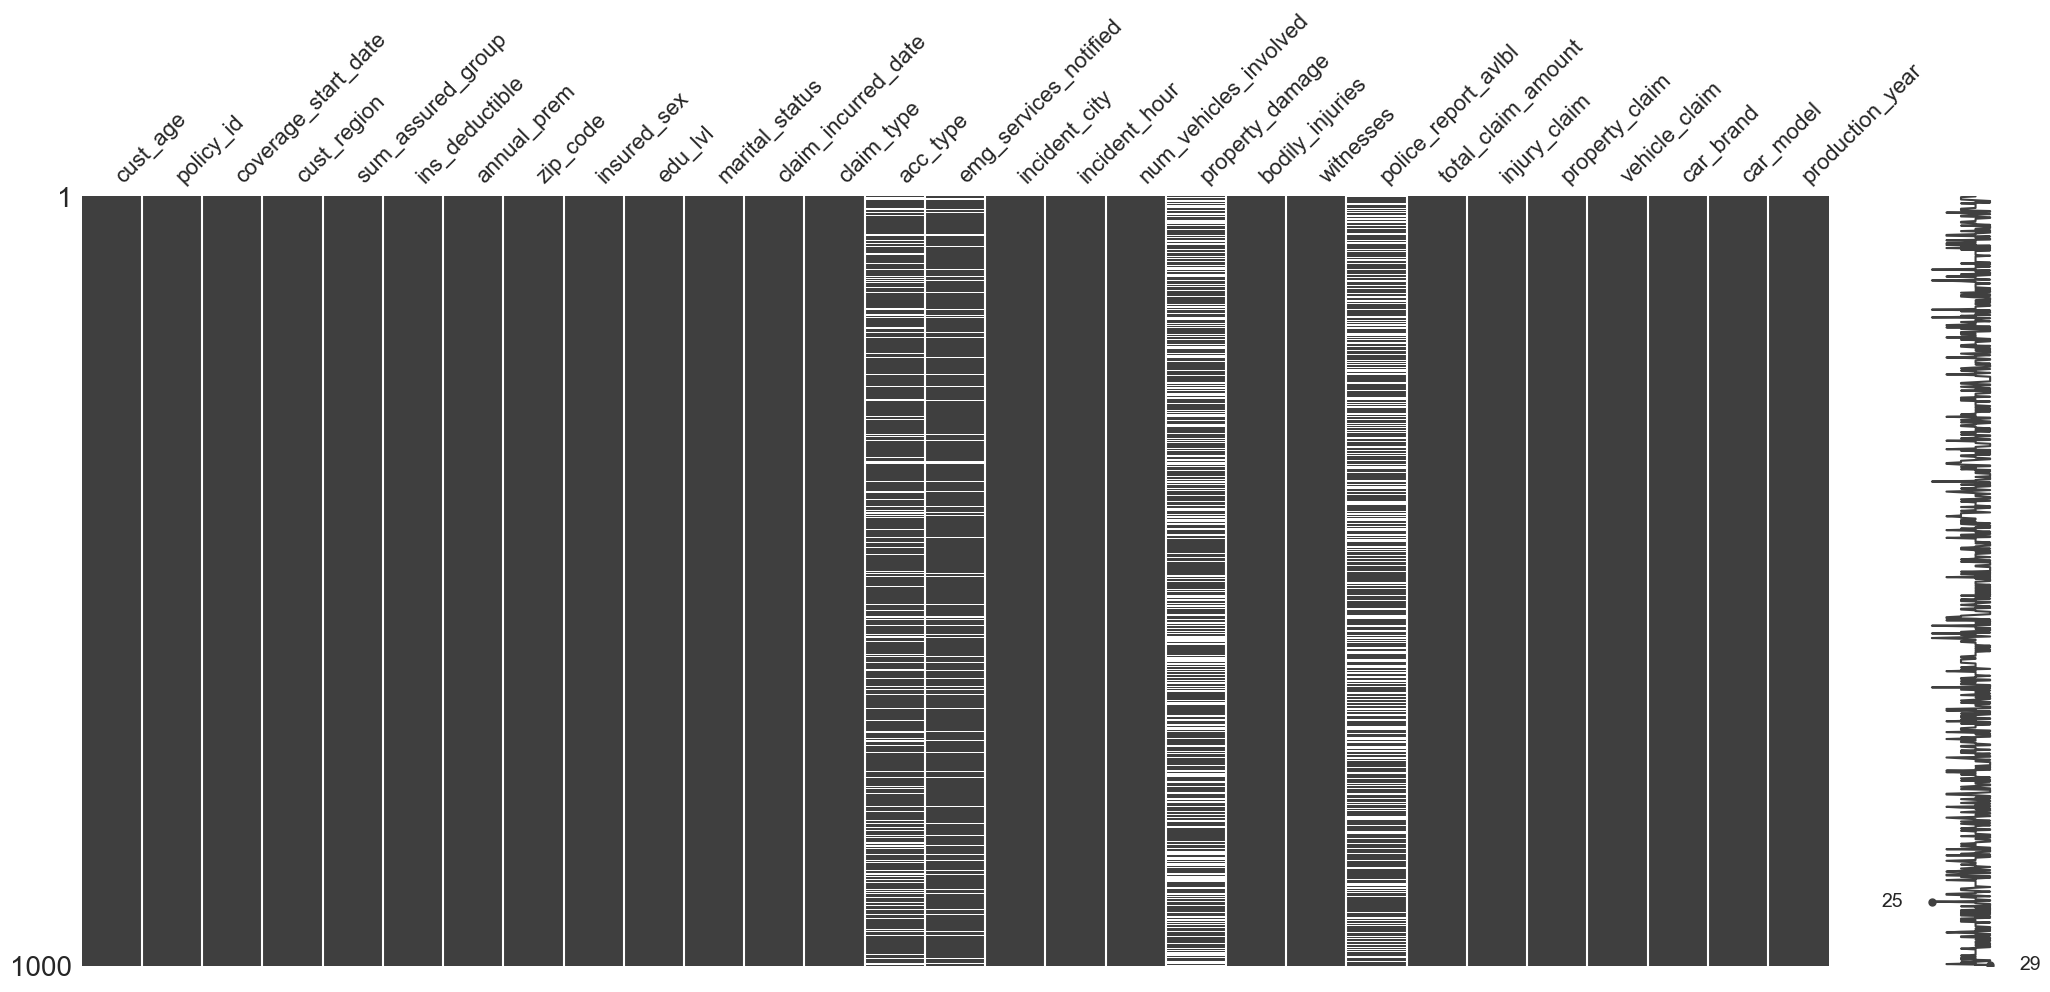

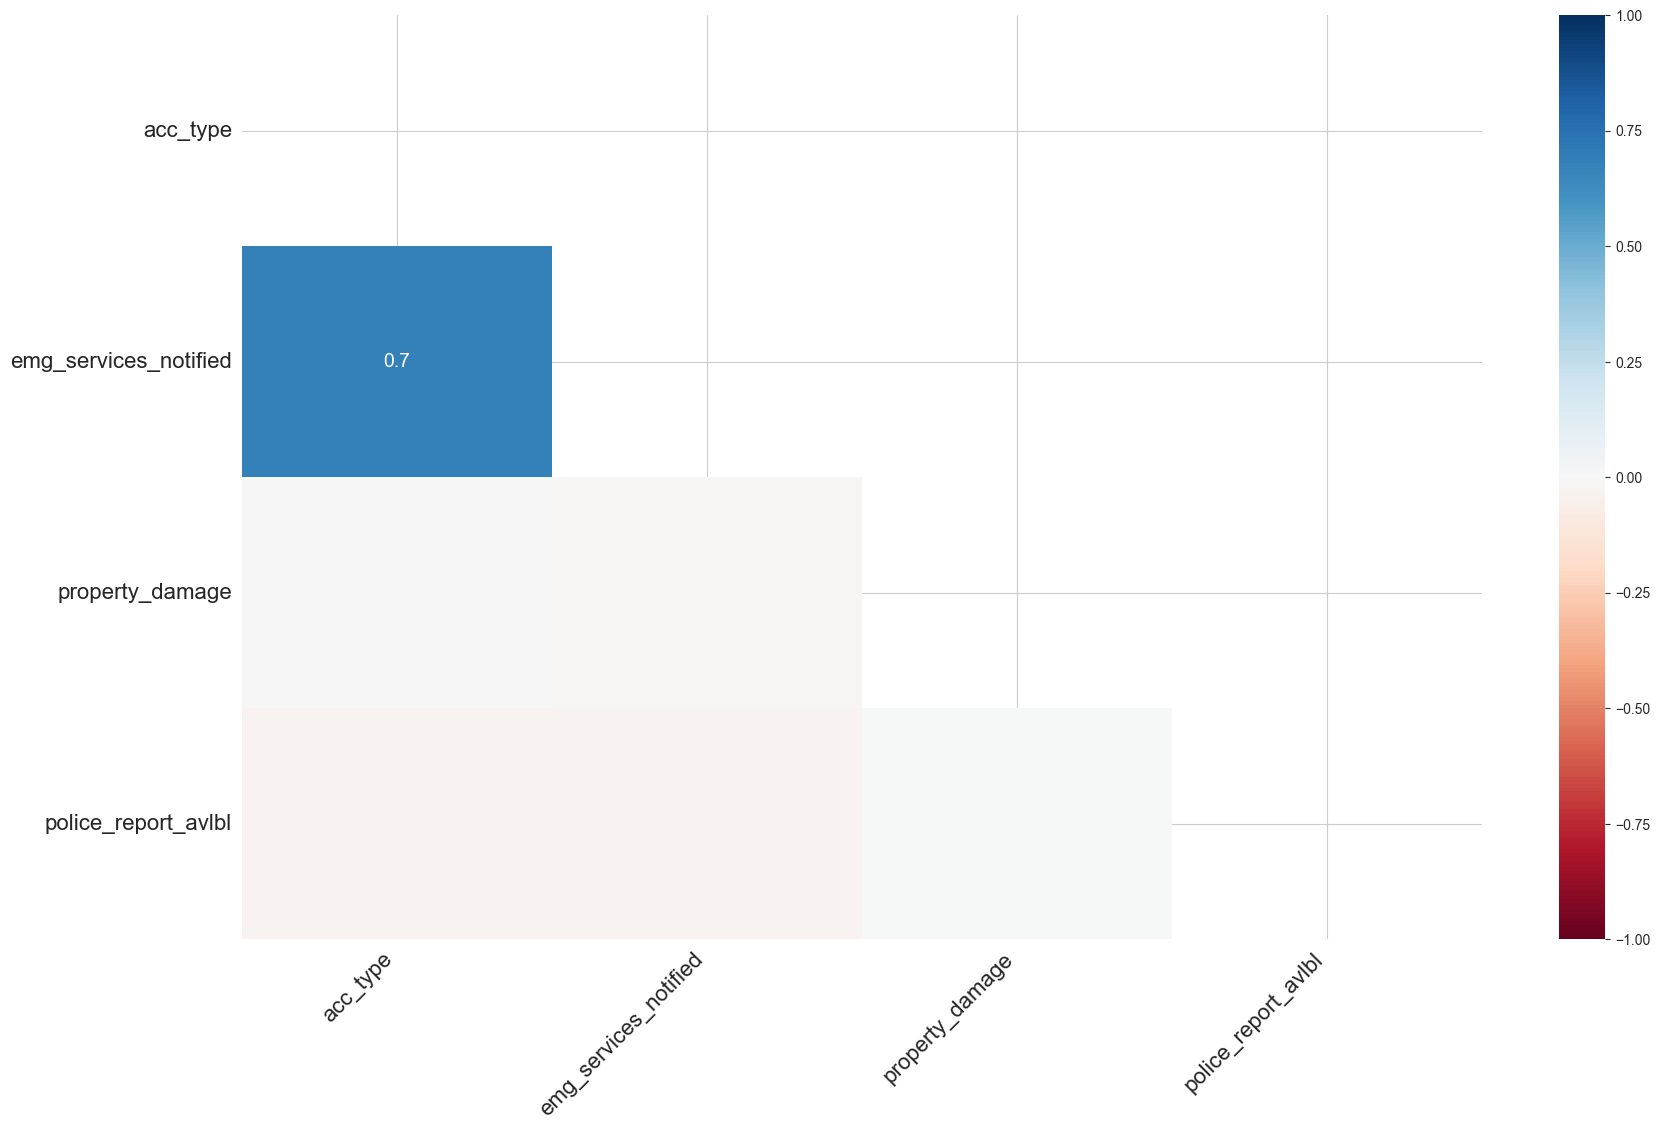

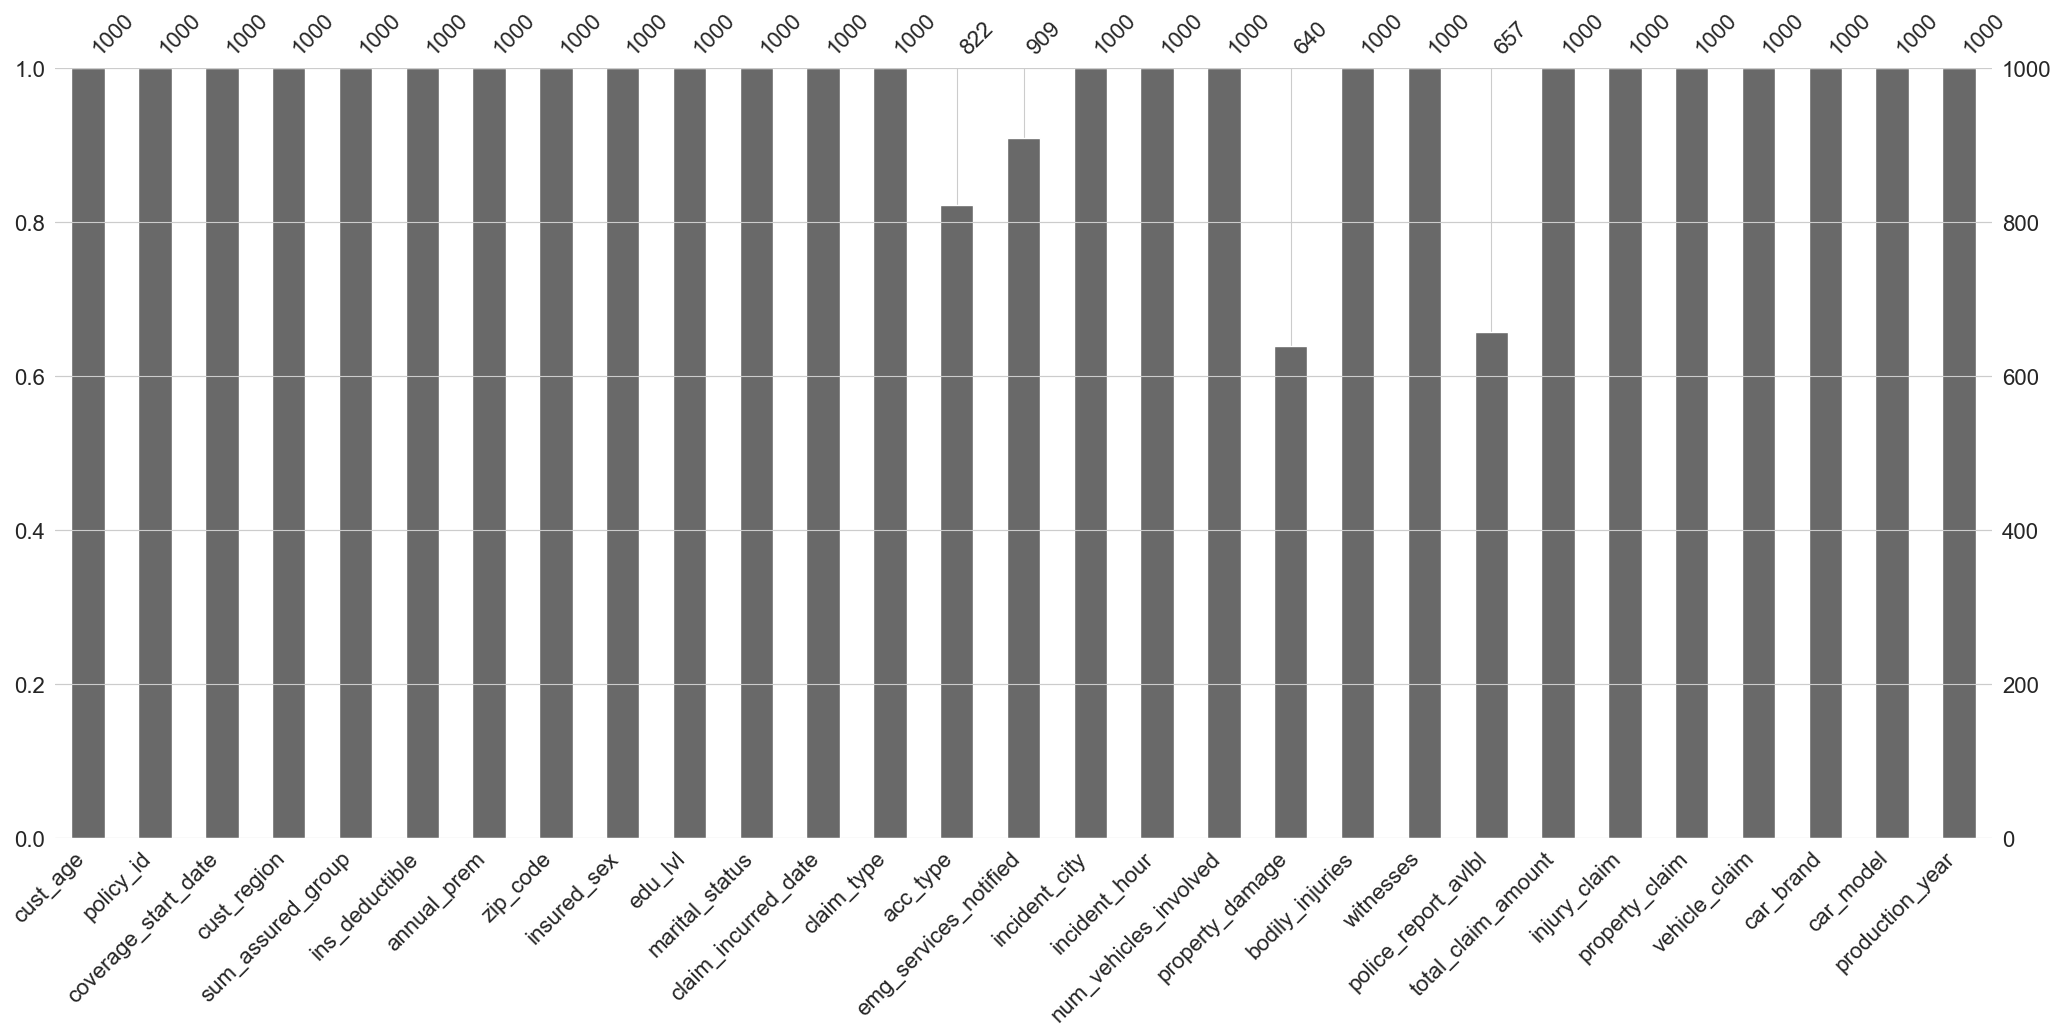

property_damage  False  True 
cust_region                  
east               232    120
north              194    116
west               214    124
emg_services_notified  False  True 
cust_region                        
east                     319     33
north                    280     30
west                     310     28
police_report_avlbl  False  True 
cust_region                      
east                   246    106
north                  196    114
west                   215    123
property_damage    False  True 
sum_assured_group              
high                 191    113
low                  227    120
mid                  222    127
emg_services_notified  False  True 
sum_assured_group                  
high                     271     33
low                      324     23
mid                      314     35
police_report_avlbl  False  True 
sum_assured_group                
high                   192    112
low                    220    127
mid                    2

In [49]:
# Initial EDA: Check for missing values
print("Initial Missing values per column:")
print(data.isnull().sum())

# Replace '?' with np.nan in the 'property_damage' column, 'None' in 'emg_services_notified' column with np.nan,
# empty spaces with np.nan too.
data['property_damage'] = data['property_damage'].replace('?', np.nan)
data['emg_services_notified'] = data['emg_services_notified'].replace('None', np.nan)
data['police_report_avlbl'] = data['police_report_avlbl'].replace('', np.nan)

# Generate descriptive statistics
print("\nDescriptive Statistics:")
print(data.describe(include='all'))

# Convert dates from strings to datetime objects with the correct format
data['coverage_start_date'] = pd.to_datetime(data['coverage_start_date'], format='%d.%m.%Y')
data['claim_incurred_date'] = pd.to_datetime(data['claim_incurred_date'], format='%d.%m.%Y')

# Visualizing the missingness pattern
msno.matrix(data)
plt.show()

# Heatmap to show correlations of missingness between different columns
msno.heatmap(data)
plt.show()

# Bar chart to show the count of missing values in each column
msno.bar(data)
plt.show()

# Cross Tabulation
for col in ['cust_region', 'sum_assured_group', 'insured_sex', 'edu_lvl', 'marital_status', 'claim_type']:
    print(pd.crosstab(data[col], data['property_damage'].isnull()))
    print(pd.crosstab(data[col], data['emg_services_notified'].isnull()))
    print(pd.crosstab(data[col], data['police_report_avlbl'].isnull()))

In [50]:
# We assume that for 'parked car' and 'theft' incidents, the 'acc_type' should be set to 'Not Applicable' and 'Minor incident',
# because the nature of missingness indicate that there is
# Set 'acc_type' to 'Not Applicable' for 'theft' incidents
data.loc[data['claim_type'] == 'theft', 'acc_type'] = 'Not Applicable'

# Set 'acc_type' to 'Minor incident' for 'parked car' incidents
data.loc[data['claim_type'] == 'parked car', 'acc_type'] = 'Minor incident'

# Impute missing values with the most common value for each of the three columns
for column in ['emg_services_notified', 'property_damage', 'police_report_avlbl']:
    most_common_value = data[column].mode()[0]
    data[column].fillna(most_common_value, inplace=True)
    print(f"Imputed missing values in '{column}' with '{most_common_value}'.")

# Check missing values count again to ensure they are filled
print("\nMissing values per column after imputation:")
print(data.isnull().sum())

Imputed missing values in 'emg_services_notified' with 'Police'.
Imputed missing values in 'property_damage' with 'NO'.
Imputed missing values in 'police_report_avlbl' with 'NO'.

Missing values per column after imputation:
cust_age                 0
policy_id                0
coverage_start_date      0
cust_region              0
sum_assured_group        0
ins_deductible           0
annual_prem              0
zip_code                 0
insured_sex              0
edu_lvl                  0
marital_status           0
claim_incurred_date      0
claim_type               0
acc_type                 0
emg_services_notified    0
incident_city            0
incident_hour            0
num_vehicles_involved    0
property_damage          0
bodily_injuries          0
witnesses                0
police_report_avlbl      0
total_claim_amount       0
injury_claim             0
property_claim           0
vehicle_claim            0
car_brand                0
car_model                0
production_year     

A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.




In [51]:
# Segment 'cust_age' into age groups
data['age_group'] = pd.cut(data['cust_age'], bins=[18, 25, 35, 45, 55, 65, np.inf], labels=['18-25', '26-35', '36-45', '46-55', '56-65', '65+'])
# Drop the 'cust_age' column if you decide it's no longer needed
data.drop('cust_age', axis=1, inplace=True)

# New features for risk analysis: Claim Frequency and Severity Metrics
# Claim Frequency Features
# Count total number of claims by policy_id
data['total_claims'] = data.groupby('policy_id')['policy_id'].transform('count')

# Claim Severity Features
# Average, max, and total claim amount by policy_id
data['avg_claim_amount'] = data.groupby('policy_id')['total_claim_amount'].transform('mean')
data['max_claim_amount'] = data.groupby('policy_id')['total_claim_amount'].transform('max')
data['total_claimed_amount'] = data.groupby('policy_id')['total_claim_amount'].transform('sum')

# Net Contribution: The net contribution of a customer to the company is the difference between the premiums paid and the claims cost. A positive value indicates profitability, while a negative value indicates a loss
# Calculate the duration of each policy in years
data['policy_duration_years'] = (data['claim_incurred_date'] - data['coverage_start_date']).dt.days / 365.25

# Calculate the total premiums paid by each customer
# Assuming 'annual_prem' is the annual premium
data['total_premiums_paid'] = data['annual_prem'] * data['policy_duration_years']

# Calculate the total claims cost for each policy
# Assuming 'total_claim_amount' is the claim amount per incident
data['total_claims_cost'] = data.groupby('policy_id')['total_claim_amount'].transform('sum')

# Calculate the net contribution for each policy
data['net_contribution'] = data['total_premiums_paid'] - data['total_claims_cost']

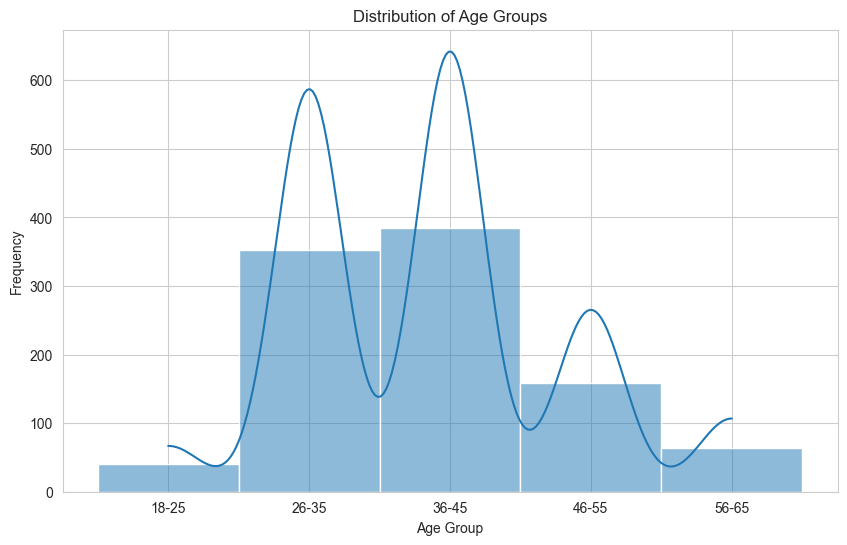

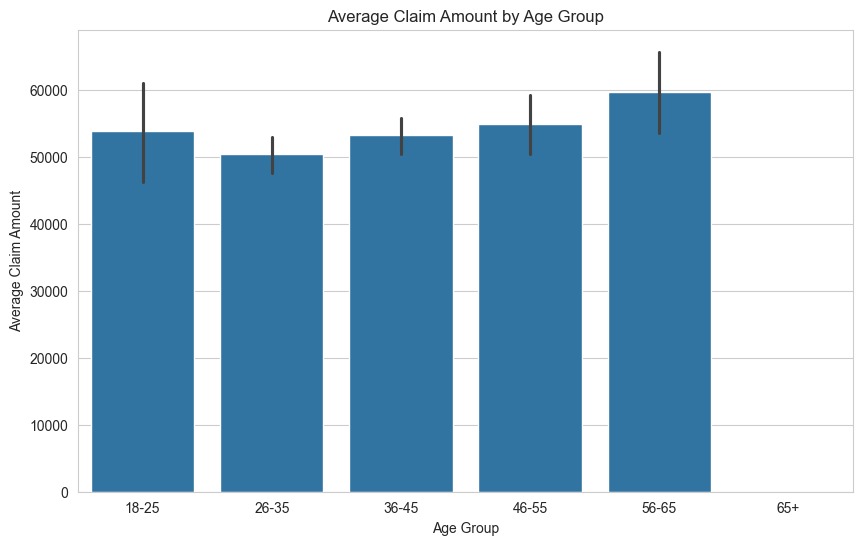

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


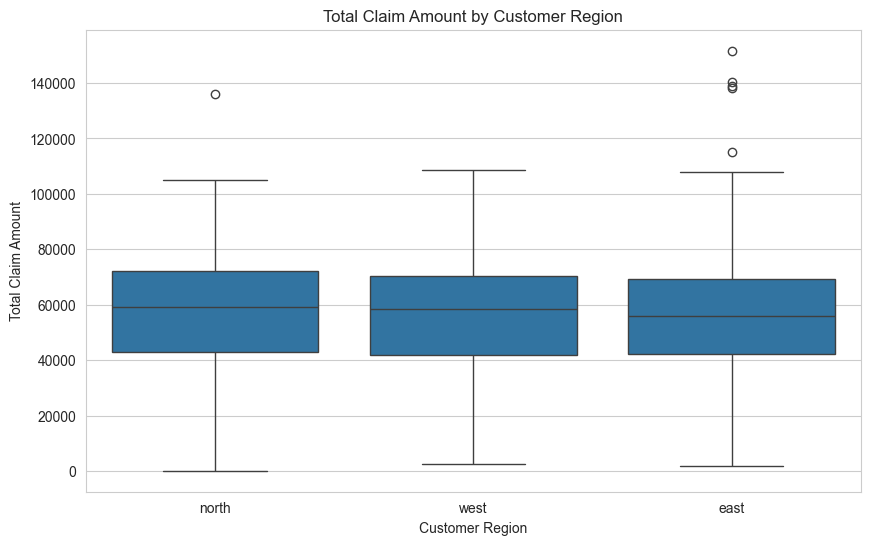

In [52]:
# Data Visualization

# Histogram of Customer Ages
plt.figure(figsize=(10, 6))
sns.histplot(data['age_group'], bins=30, kde=True)
plt.title('Distribution of Age Groups')
plt.xlabel('Age Group')
plt.ylabel('Frequency')
plt.show()

#Average Claim amount by age
plt.figure(figsize=(10, 6))
sns.barplot(x='age_group', y='avg_claim_amount', data=data)
plt.title('Average Claim Amount by Age Group')
plt.xlabel('Age Group')
plt.ylabel('Average Claim Amount')
plt.show()

# Boxplot of Total Claim Amount by Customer Region
plt.figure(figsize=(10, 6))
sns.boxplot(x='cust_region', y='total_claimed_amount', data=data)
plt.title('Total Claim Amount by Customer Region')
plt.xlabel('Customer Region')
plt.ylabel('Total Claim Amount')
plt.show()

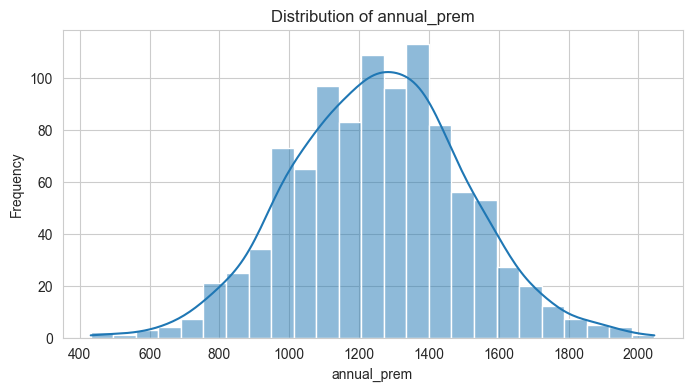

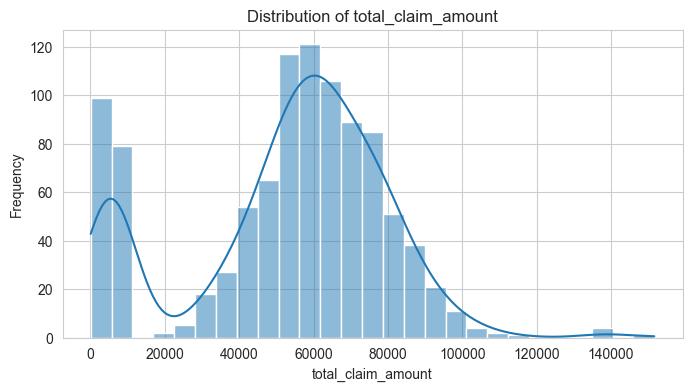

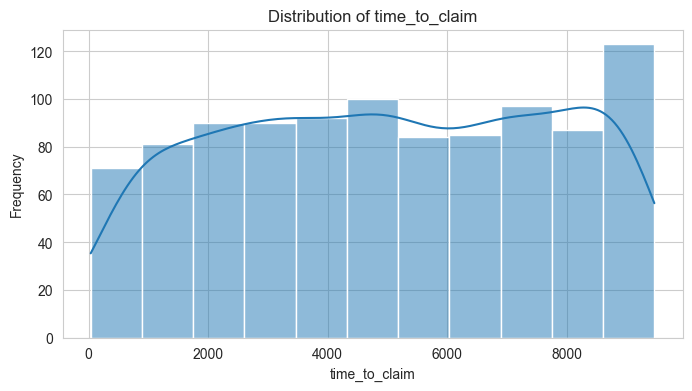

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


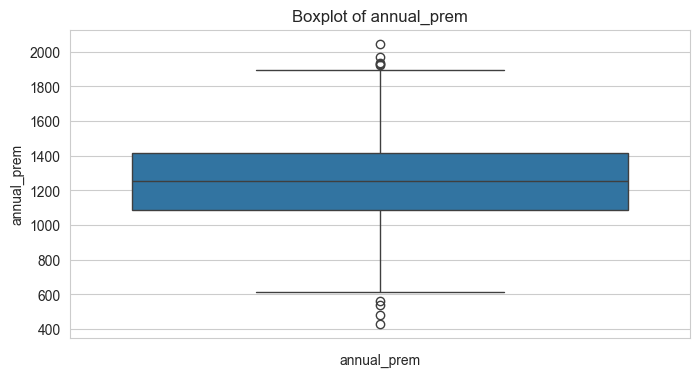

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


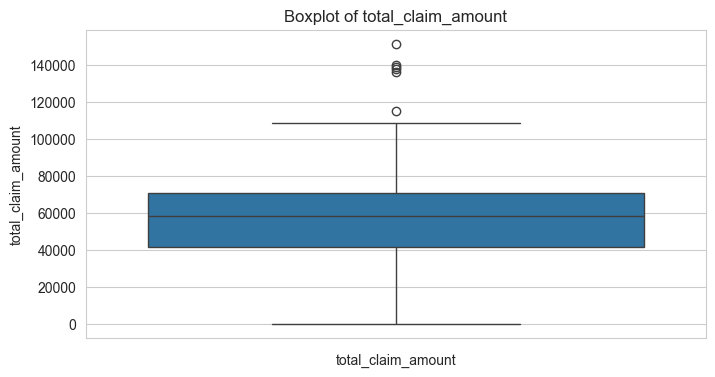

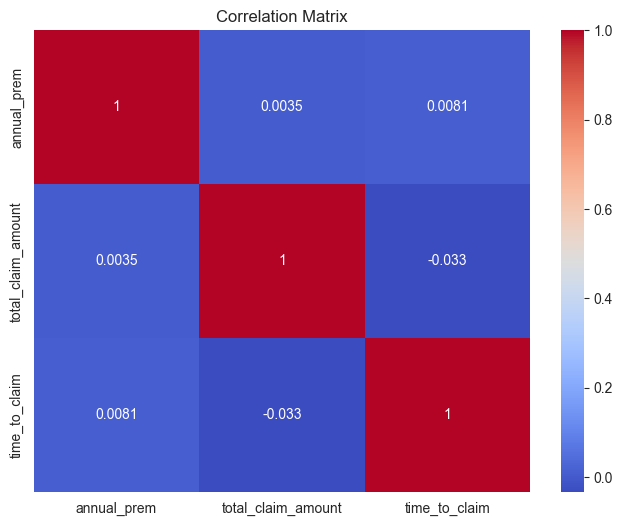

In [53]:
# Checking the distribution of key features
data['time_to_claim'] = (data['claim_incurred_date'] - data['coverage_start_date']).dt.days

for col in ['annual_prem', 'total_claim_amount', 'time_to_claim']:
    plt.figure(figsize=(8, 4))
    sns.histplot(data[col], kde=True)
    plt.title(f'Distribution of {col}')
    plt.ylabel('Frequency')
    plt.xlabel(col)
    plt.show()

# Checking for outliers
for col in ['annual_prem', 'total_claim_amount']:
    plt.figure(figsize=(8, 4))
    sns.boxplot(data[col])
    plt.title(f'Boxplot of {col}')
    plt.xlabel(col)
    plt.show()

# Correlation Analysis
correlation_matrix = data[['annual_prem', 'total_claim_amount', 'time_to_claim']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Matrix')
plt.show()

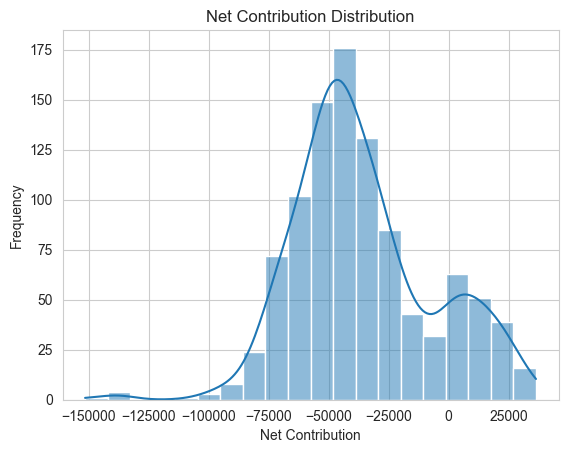

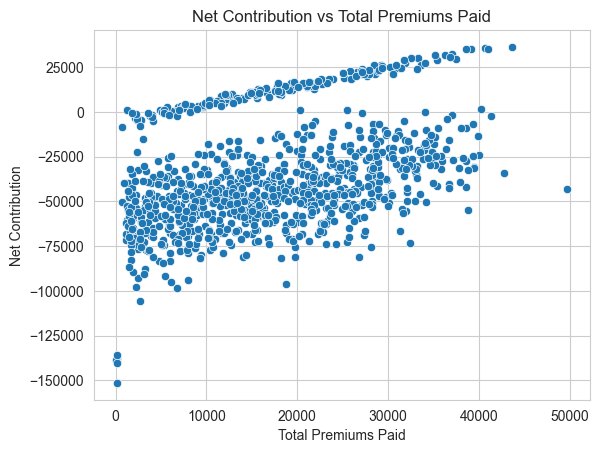

In [54]:
# Profitability
sns.histplot(data['net_contribution'], bins=20, kde=True)
plt.title('Net Contribution Distribution')
plt.xlabel('Net Contribution')
plt.ylabel('Frequency')
plt.show()

sns.scatterplot(x='total_premiums_paid', y='net_contribution', data=data)
plt.title('Net Contribution vs Total Premiums Paid')
plt.xlabel('Total Premiums Paid')
plt.ylabel('Net Contribution')
plt.show()

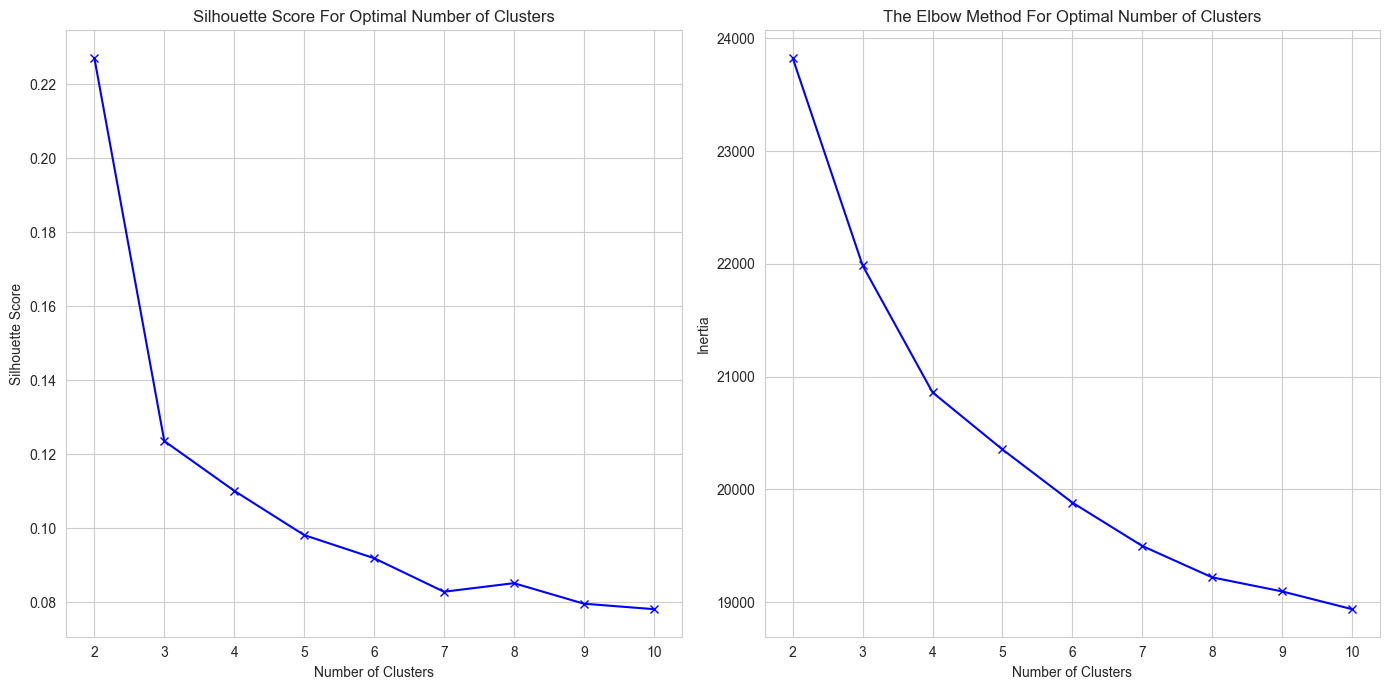

In [55]:
# Replace 'numerical_cols' and 'categorical_cols' with column names
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns
categorical_cols = data.select_dtypes(include=['object']).columns

# Create transformers for numerical and categorical data
numerical_transformer = StandardScaler()
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Combine transformers into a preprocessor
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

# Apply the preprocessor
X_preprocessed = preprocessor.fit_transform(data)

# Define the range of clusters to try
range_n_clusters = range(2, 11)

# Initialize lists to store the results of the silhouette score and inertia
silhouette_avg_scores = []
inertia_scores = []

# Calculate silhouette score and inertia for different numbers of clusters
for n_clusters in range_n_clusters:
    # Initialize the clusterer with n_clusters value and a random generator seed for reproducibility.
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_preprocessed)

    # Silhouette score
    silhouette_avg = silhouette_score(X_preprocessed, cluster_labels)
    silhouette_avg_scores.append(silhouette_avg)

    # Inertia
    inertia_scores.append(clusterer.inertia_)

# Plotting the silhouette scores
plt.figure(figsize=(14, 7))

plt.subplot(1, 2, 1)
plt.plot(range_n_clusters, silhouette_avg_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score For Optimal Number of Clusters')

# Plotting the elbow method results
plt.subplot(1, 2, 2)
plt.plot(range_n_clusters, inertia_scores, 'bx-')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('The Elbow Method For Optimal Number of Clusters')

plt.tight_layout()
plt.show()

In [59]:
# TruncatedSVD, K-Means clustering
# Define which columns are categorical
categorical_cols = data.select_dtypes(include=['object', 'bool']).columns.tolist()
# Define which columns are numerical
numerical_cols = data.select_dtypes(include=['int64', 'float64']).columns.tolist()
# Preprocessing for numerical data
numerical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])
# Preprocessing for categorical data
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore'))
])
# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])
# Applying the preprocessor
X_preprocessed = preprocessor.fit_transform(data)

# Calculate the cumulative explained variance ratio
cumulative_variance = np.cumsum(svd.explained_variance_ratio_)

# Determine the number of components to retain 95% of the variance
n_components_95 = np.argmax(cumulative_variance >= 0.95) + 1  # +1 because indices start at 0

# Now, reapply TruncatedSVD with the chosen number of components
svd_95 = TruncatedSVD(n_components=n_components_95)
X_svd_95 = svd_95.fit_transform(X_preprocessed)

# Then determine the optimal number of clusters using silhouette scores
range_n_clusters = range(2, 11)
best_n_clusters = 0
best_silhouette_score = -1

for n_clusters in range_n_clusters:
    clusterer = KMeans(n_clusters=n_clusters, random_state=42)
    cluster_labels = clusterer.fit_predict(X_svd)  # Using SVD-transformed data
    silhouette_avg = silhouette_score(X_svd, cluster_labels)

    # Check if this silhouette score is the best one so far
    if silhouette_avg > best_silhouette_score:
        best_n_clusters = n_clusters
        best_silhouette_score = silhouette_avg

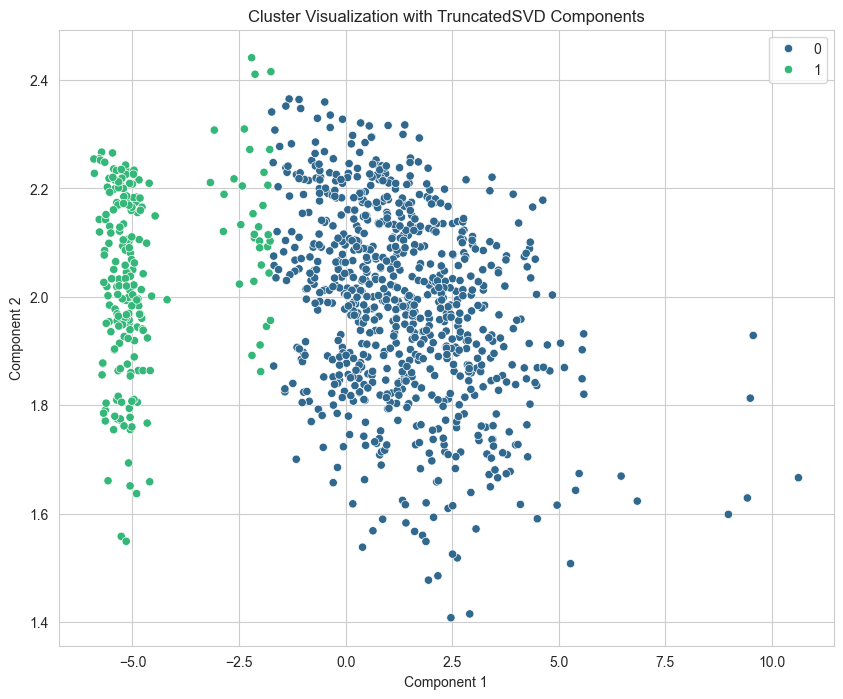

Potential Outlier IDs:
[113947 310312 301512 226009 132045 438097 335131 500283 130053 211077
 209446 113442 453588]


In [63]:
# Apply K-Means clustering on the reduced SVD data
kmeans = KMeans(n_clusters=best_n_clusters, init='k-means++', random_state=42)
cluster_labels = kmeans.fit_predict(X_svd_95)

# Create a DataFrame for the SVD results for easy plotting
column_names = [f'Component_{i+1}' for i in range(X_svd_95.shape[1])]
svd_df = pd.DataFrame(X_svd_95, columns=column_names)
svd_df['Cluster'] = cluster_labels

# Plotting the clusters using the first two SVD components
plt.figure(figsize=(10, 8))
sns.scatterplot(x='Component_1', y='Component_2', hue='Cluster', data=svd_df, palette='viridis')
plt.title('Cluster Visualization with TruncatedSVD Components')
plt.xlabel('Component 1')
plt.ylabel('Component 2')
plt.legend()
plt.show()

# Calculate the centroids for the reduced dimensionality data
centroids = kmeans.cluster_centers_

# Calculate distances from each point to its cluster centroid in the reduced space
distances = np.linalg.norm(X_svd_95 - centroids[cluster_labels, :], axis=1)

# Set a threshold for outlier detection, e.g., beyond 2 standard deviations of the mean distance
threshold = np.mean(distances) + 2.4 * np.std(distances)

# Identify potential outlier indices
outlier_indices = np.where(distances > threshold)[0]

# Retrieve the original IDs of the outliers
outlier_ids = data.iloc[outlier_indices]['policy_id'].values

print("Potential Outlier IDs:")
print(outlier_ids)

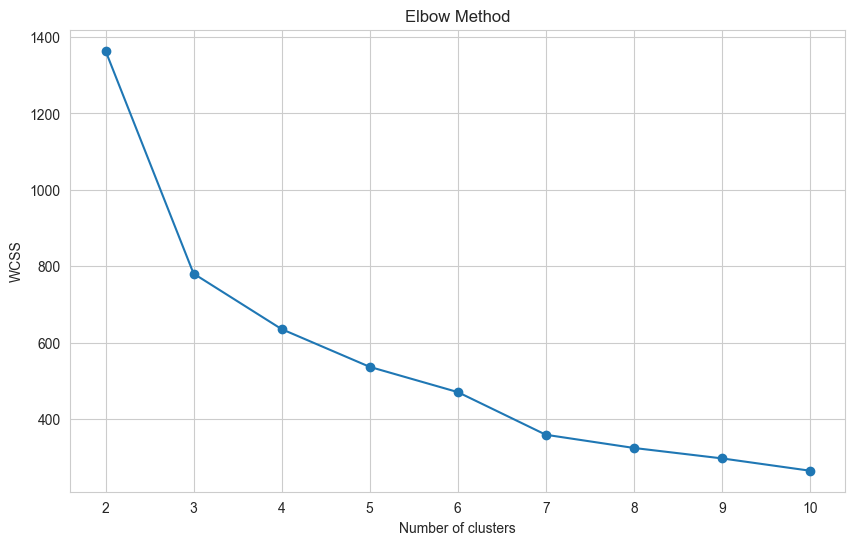

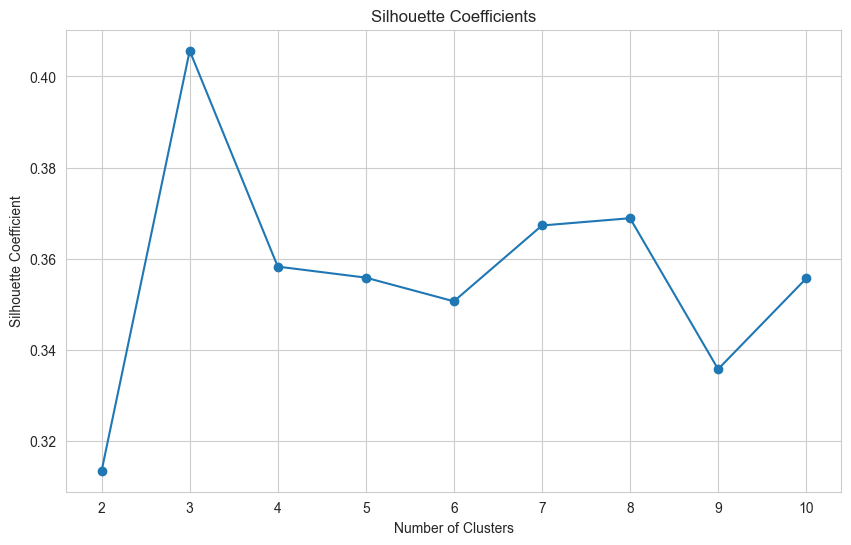

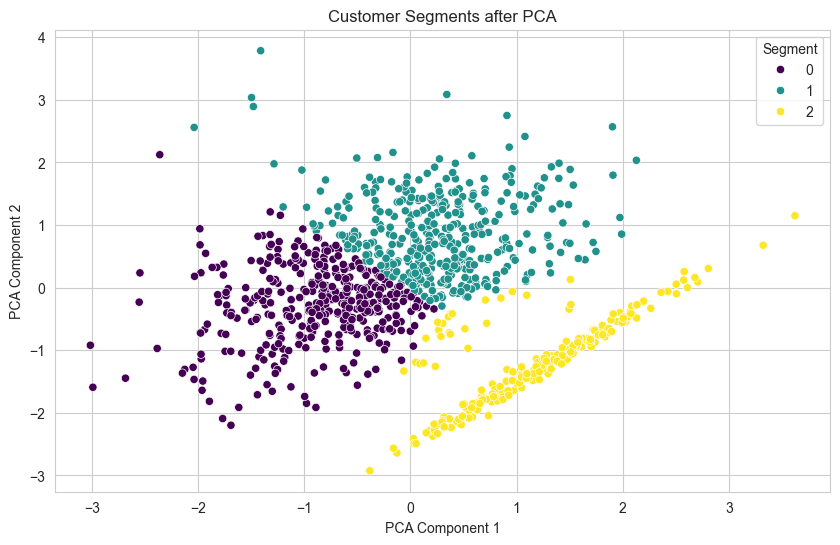


Segment 0 Statistics:
            policy_id            coverage_start_date  ins_deductible  \
count     394.000000                            394      394.000000   
mean   331972.139594  2009-03-21 06:16:26.802030336     1119.289340   
min     61764.000000            1997-04-23 00:00:00      500.000000   
25%    208128.750000            2002-05-25 06:00:00      500.000000   
50%    317477.000000            2009-04-04 00:00:00     1000.000000   
75%    467014.500000            2016-03-04 06:00:00     2000.000000   
max    600601.000000            2022-12-15 00:00:00     2000.000000   
std    156900.218088                            NaN      607.194778   

       annual_prem       zip_code            claim_incurred_date  \
count   394.000000     394.000000                            394   
mean   1455.813096  403768.969543  2023-01-28 17:32:35.329949184   
min    1259.390000  330348.000000            2023-01-01 00:00:00   
25%    1341.905000  349371.250000            2023-01-13 00:00:00

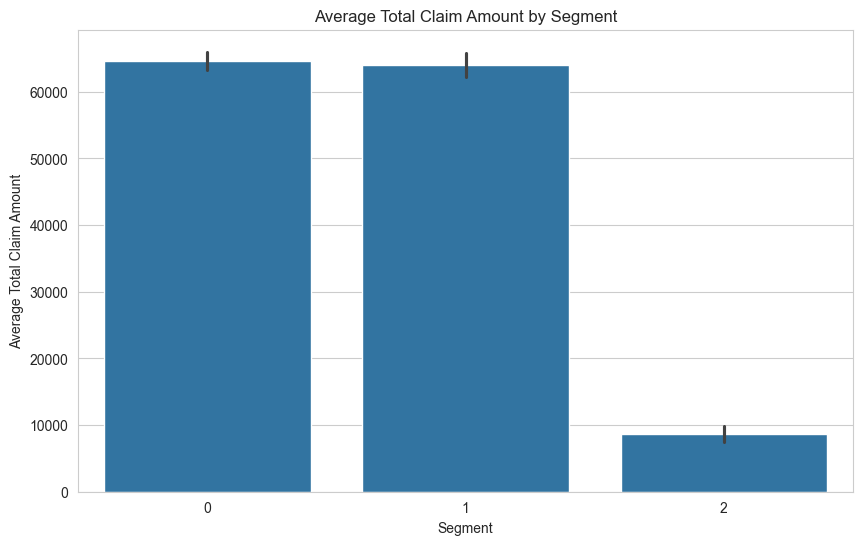

SeriesGroupBy.grouper is deprecated and will be removed in a future version of pandas.


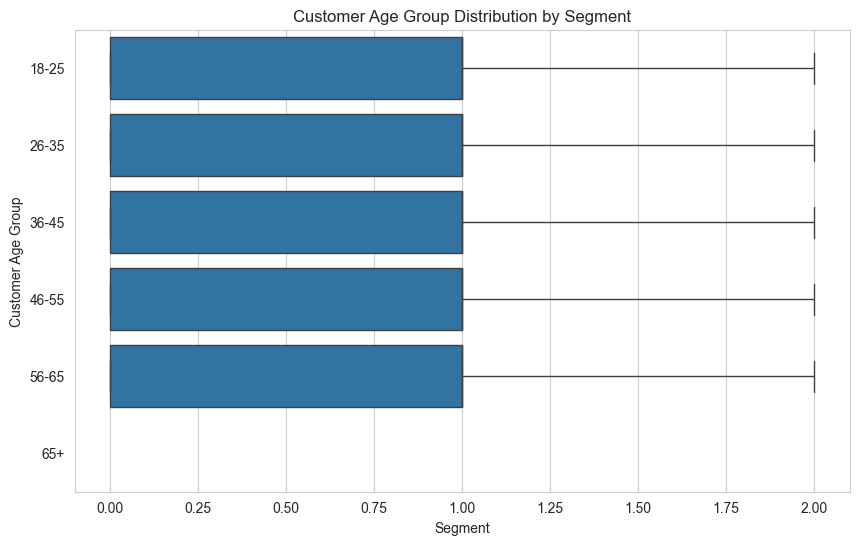

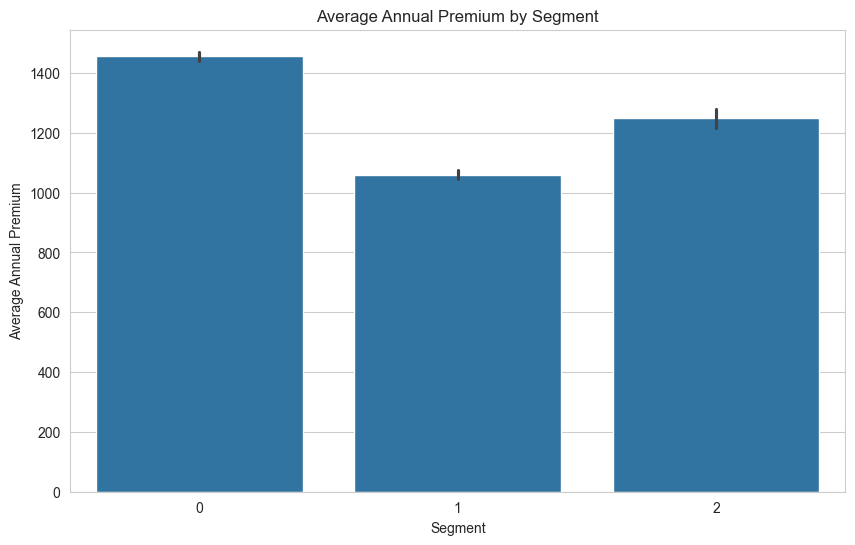

In [61]:
# Second Approach to Segmentation
# Feature Selection for Clustering
features = data[['annual_prem', 'total_claim_amount']]  # Adjust based on our EDA
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

# Step 2: Dimensionality Reduction using PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Step 3: Finding the Optimal Number of Clusters
wcss = []
silhouette_coefficients = []
for k in range(2, 11):  # Test different numbers of clusters
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_pca)
    wcss.append(kmeans.inertia_)
    score = silhouette_score(features_pca, kmeans.labels_)
    silhouette_coefficients.append(score)

# Elbow Method Plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), wcss, marker='o')
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

# Silhouette Coefficient Plot
plt.figure(figsize=(10, 6))
plt.plot(range(2, 11), silhouette_coefficients, marker='o')
plt.title('Silhouette Coefficients')
plt.xlabel('Number of Clusters')
plt.ylabel('Silhouette Coefficient')
plt.show()

# Choose the number of clusters based on the plots and set it in the final K-means model
optimal_clusters = 3

# Step 4: Final K-means Clustering
kmeans_final = KMeans(n_clusters=optimal_clusters, random_state=42)
data['segment_label'] = kmeans_final.fit_predict(features_pca)

# Step 5: Visualization of Segments
plt.figure(figsize=(10, 6))
sns.scatterplot(x=features_pca[:, 0], y=features_pca[:, 1], hue=data['segment_label'], palette='viridis')
plt.title('Customer Segments after PCA')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.legend(title='Segment')
plt.show()

# Additional segment analysis and visualizations
# Segment-wise Descriptive Statistics
for i in range(optimal_clusters):
    print(f"\nSegment {i} Statistics:\n", data[data['segment_label'] == i].describe())

# Visualizing Segment-wise Average Claim Amounts
plt.figure(figsize=(10, 6))
sns.barplot(x='segment_label', y='total_claim_amount', data=data, estimator=np.mean)
plt.title('Average Total Claim Amount by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Total Claim Amount')
plt.show()

# Visualizing Segment-wise Customer Age Distribution
plt.figure(figsize=(10, 6))
sns.boxplot(x='segment_label', y='age_group', data=data)
plt.title('Customer Age Group Distribution by Segment')
plt.xlabel('Segment')
plt.ylabel('Customer Age Group')
plt.show()

# Visualizing Segment-wise Annual Premium
plt.figure(figsize=(10, 6))
sns.barplot(x='segment_label', y='annual_prem', data=data, estimator=np.mean)
plt.title('Average Annual Premium by Segment')
plt.xlabel('Segment')
plt.ylabel('Average Annual Premium')
plt.show()

In [68]:
# Naming the outliers
iso_forest = IsolationForest(contamination=0.01) # contamination is an estimate of the proportion of outliers
outliers = iso_forest.fit_predict(features_pca)

# Find the index of outliers
outlier_indices = np.where(outliers == -1)[0]

# Map indices to original data
suspicious_policy_ids = data.iloc[outlier_indices]['policy_id'].values

# Print suspicious policy IDs
print(suspicious_policy_ids)

[113947 197075 310312 132045 146219 438097 139416 209446 591955 453588]


[113947 197075 310312 132045 146219 139416 433275 209446 591955 453588]
     policy_id  total_claim_amount  injury_claim  property_claim  \
285     132045              151632         23328           23328   
699     209446              140270         14027           28054   
82      310312              139048         10696           21392   
26      113947              138138         21252           21252   
870     453588              135993         24726           24726   

     vehicle_claim police_report_avlbl  anomaly_score    edu_lvl  
285         104976                 YES             -1         jd  
699          98189                  NO             -1    masters  
82          106960                  NO             -1  associate  
26           95634                  NO             -1         jd  
870          86541                  NO             -1         md  


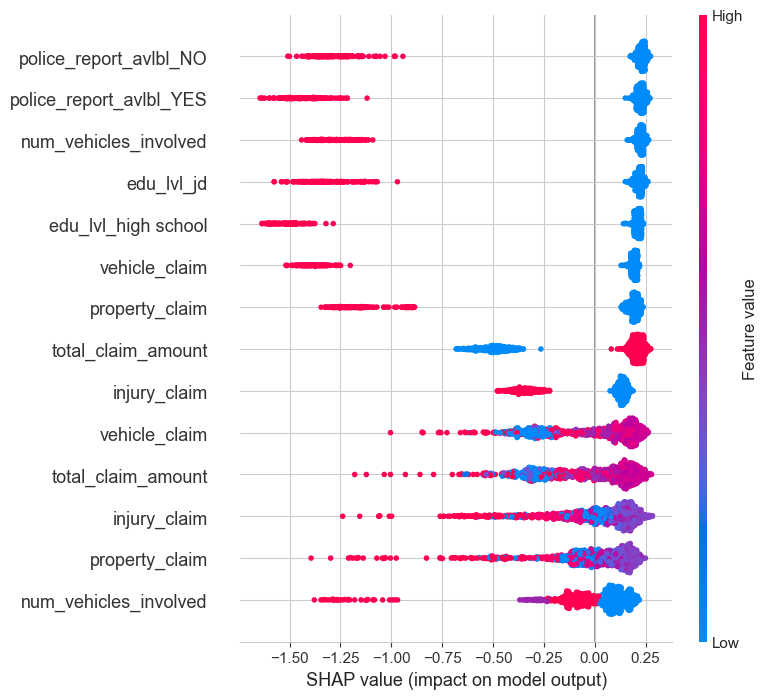

[113947 197075 310312 132045 146219 438097 433275 209446 591955 453588]


In [70]:
# Identifying outliers using Isolation Forest
iso_forest = IsolationForest(contamination=0.01)  # contamination is an estimate of the proportion of outliers
outliers = iso_forest.fit_predict(features_pca)

# Find the indices of outliers
outlier_indices = np.where(outliers == -1)[0]

# Map the indices to original data to get suspicious policy IDs
suspicious_policy_ids = data.iloc[outlier_indices]['policy_id'].values

# Print suspicious policy IDs
print(suspicious_policy_ids)

# Define numerical and categorical features for preprocessing
numerical_features = ['total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'num_vehicles_involved']
categorical_features = ['police_report_avlbl', 'edu_lvl']

# Create a preprocessor for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),  # Standardize numerical features
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)  # One-hot encode categorical features
    ])

# Initialize Isolation Forest for anomaly detection
iso_forest = IsolationForest(n_estimators=100, contamination=0.01, random_state=42)

# Create a pipeline that preprocesses the data and then applies the Isolation Forest model
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('model', iso_forest)])

# Combine numerical and categorical features for input data
X = data[numerical_features + categorical_features]

# Fit the pipeline on the data
pipeline.fit(X)

# Predict anomalies in the data
anomalies = pipeline.predict(X)

# Add the anomaly score to the original data
data['anomaly_score'] = anomalies

# Sort the anomalies and select the top 5 based on the total claim amount
anomalies_df = data[data['anomaly_score'] == -1].sort_values('total_claim_amount', ascending=False)
top_anomalies = anomalies_df.head(5)

# Display the top anomalies with relevant details
print(top_anomalies[
          ['policy_id', 'total_claim_amount', 'injury_claim', 'property_claim', 'vehicle_claim', 'police_report_avlbl',
           'anomaly_score', 'edu_lvl']])

# Transform the input data for SHAP analysis
X_transformed = preprocessor.fit_transform(X)

# Generate new feature names after one-hot encoding
new_feature_names = numerical_features.copy()
for feature in categorical_features:
    unique_values = data[feature].unique()
    for value in unique_values:
        new_feature_names.append(f"{feature}_{value}")
all_feature_names = numerical_features + list(new_feature_names)

# Explain the Isolation Forest model using SHAP
explainer = shap.TreeExplainer(pipeline.named_steps['model'])

# Calculate SHAP values for the transformed data
shap_values = explainer.shap_values(X_transformed)

# Plot the summary of SHAP values to show feature importance
shap.summary_plot(shap_values, features=X_transformed, feature_names=all_feature_names)

# Print the policy IDs again for verification
outliers = iso_forest.fit_predict(features_pca)

# Find the indices of outliers again
outlier_indices = np.where(outliers == -1)[0]

# Map the indices to original data to get suspicious policy IDs
suspicious_policy_ids = data.iloc[outlier_indices]['policy_id'].values

# Print suspicious policy IDs
print(suspicious_policy_ids)
